In [1]:
import os
import analysis
import getpass
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude
import matplotlib.pyplot as plt

In [2]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "mean_amplitude" : mean_amplitude,
}

user = getpass.getuser()
# e.g. use in your code:
if user == 'ashankar':
    data_root = '/scratch/shared'
else:
    data_root = '..'

h5_files = [os.path.join(f"{data_root}/data/data_rand", f) for f in os.listdir(f'{data_root}/data/data_rand') if f.endswith('.h5')]

df = analysis.load_outputs_to_dataframe(h5_files)
df = analysis.attach_hypotheses_fields(df, hypotheses)
print(len(df))

230


In [3]:
def filter_dataframe_by_range(df, field, lower_bound, upper_bound):
    """
    Filters the DataFrame to include only rows where the specified field's values
    are within the given range (exclusive).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        field (str): The column name to filter by.
        lower_bound (float): The lower bound of the range (exclusive).
        upper_bound (float): The upper bound of the range (exclusive).

    Returns:
        pd.DataFrame: A filtered DataFrame.
    """
    return df[(df[field] > lower_bound) & (df[field] < upper_bound)]

/tmp/ipykernel_2226526/4114662691.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


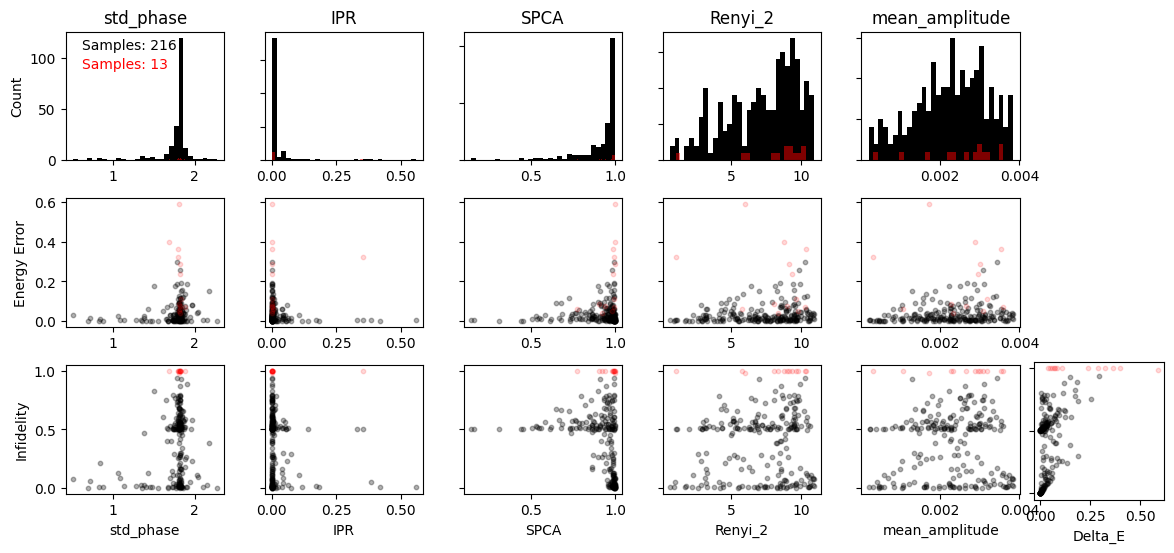

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plotCorrelations(df_eval, hypotheses, plt_fig=None, text_offset=None, color="black", alphamod=1., ylog=False):
    scatter_size = 10
    N = len(hypotheses)
    if plt_fig is None:
        fig = plt.figure(figsize=(0.6*4*N + 1, 0.6*10))  # Extra width for colorbar
        gs = gridspec.GridSpec(3, N+1, width_ratios=[1]*N + [0.08], wspace=0.3, hspace=0.3)
        axes = np.empty((3, N), dtype=object)
        for row in range(3):
            for col in range(N):
                axes[row, col] = fig.add_subplot(gs[row, col])
        bottom_right_ax = fig.add_subplot(gs[-1, -1])
        
    else:
        fig = plt_fig
        all_axes = fig.get_axes()
        axes = np.array(all_axes[:3*N]).reshape(3, N)
        bottom_right_ax = all_axes[-1]
        # The last axis (all_axes[3*N]) is the colorbar or extra axis

    for idx, name in enumerate(hypotheses.keys()):
        if name == "mean_phase":
            data = df_eval[name].abs()
            title = f"|{name}|"
        else:
            data = df_eval[name]
            title = name
        axes[0, idx].hist(data, bins=30, color=color,alpha = alphamod)
        axes[0, idx].set_title(title)
        if idx == 0:
            axes[0, 0].set_ylabel("Count")
        else:
            axes[0, idx].tick_params(axis='y', labelleft=False)

        scatter = axes[1, idx].scatter(data, df_eval["Delta_E"], alpha=0.3*alphamod, s=scatter_size, color=color)
        if idx == 0:
            axes[1, 0].set_ylabel("Energy Error")
        else:
            axes[1, idx].tick_params(axis='y', labelleft=False)
        axes[2, idx].scatter(data, df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
        axes[2, idx].set_xlabel(title)
        if idx == 0:
            axes[2, 0].set_ylabel("Infidelity")
        else:
            axes[2, idx].tick_params(axis='y', labelleft=False)

        if ylog:
            # apply log scale to y-axis for all three rows for this column
            axes[0, idx].set_yscale('log')
            axes[1, idx].set_yscale('log')
            axes[2, idx].set_yscale('log')

    plt.tight_layout()

    bottom_right_ax.set_position([0.87, 0.1, 0.1, 0.23])
    bottom_right_ax.tick_params(axis='y', labelleft=False)
    bottom_right_ax.scatter(df_eval["Delta_E"], df_eval["infidelity"], alpha=0.3*alphamod, s=scatter_size, color=color)
    bottom_right_ax.set_xlabel("Delta_E")
    if ylog:
        bottom_right_ax.set_yscale('log')
    if text_offset is None:
        text_offset = [0,0]
        if plt_fig is not None:
            text_offset = [0.0,-0.15]
    text_pos = np.array([0.1, 0.95]) + np.array(text_offset)
    axes[0, 0].text(*text_pos, f"Samples: {len(df_eval)}", transform=axes[0, 0].transAxes, fontsize=10, color=color, ha="left", va="top")
    return fig

infidelityrange = (0,0.95)
df_eval = filter_dataframe_by_range(df, 'infidelity', *infidelityrange)
plt_fig = plotCorrelations(df_eval,hypotheses)
infidelityrange = (0.95,1)
df_eval_min = filter_dataframe_by_range(df, 'infidelity', *infidelityrange)

plt_fig = plotCorrelations(df_eval_min,hypotheses,color="red",alphamod=0.5,plt_fig=plt_fig)

In [5]:
df_eval["IPR"]

0      0.001302
1      0.000024
2      0.000859
3      0.000188
4      0.000145
         ...   
224    0.000171
225    0.000029
226    0.000530
228    0.013159
229    0.184297
Name: IPR, Length: 216, dtype: float64

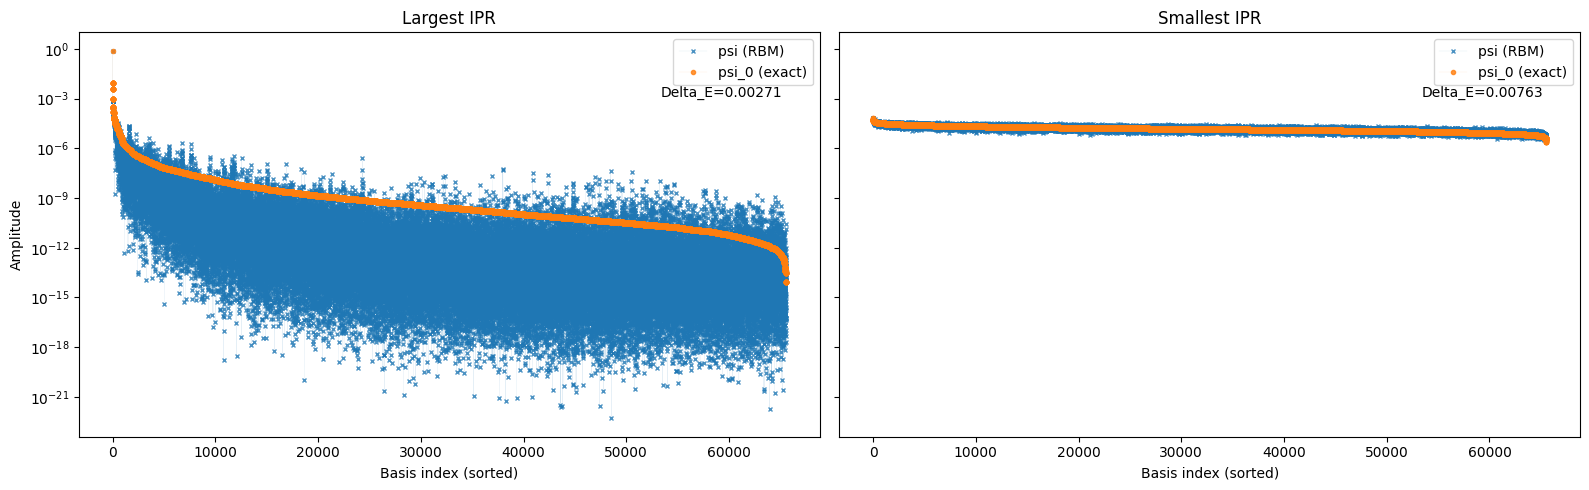

In [6]:
import numpy as np

# Find the index of the row with the largest IPR in df_eval
# Find indices of the row with largest and smallest IPR in df_eval
max_ipr_idx = df_eval["IPR"].idxmax()
min_ipr_idx = df_eval["IPR"].idxmin()

perm = np.argsort(df_eval["IPR"])
# max_ipr_idx = np.int64(32)
# min_ipr_idx = 1

# Extract psi_0 and psi for those rows
psi_0_max_ipr = df_eval.loc[max_ipr_idx, "psi_0"]
psi_max_ipr = df_eval.loc[max_ipr_idx, "psi"]
psi_0_min_ipr = df_eval.loc[min_ipr_idx, "psi_0"]
psi_min_ipr = df_eval.loc[min_ipr_idx, "psi"]

perm_max_ipr = np.argsort(np.abs(psi_0_max_ipr))[::-1]
psi_0_max_ipr = psi_0_max_ipr[perm_max_ipr]
psi_max_ipr = psi_max_ipr[perm_max_ipr]

# For min IPR
perm_min_ipr = np.argsort(np.abs(psi_0_min_ipr))[::-1]
psi_0_min_ipr = psi_0_min_ipr[perm_min_ipr]
psi_min_ipr = psi_min_ipr[perm_min_ipr]

# Convert psi_0 and psi to numpy arrays for plotting
psi_0_max_ipr_arr = np.array(psi_0_max_ipr)
psi_max_ipr_arr = np.array(psi_max_ipr)
psi_0_min_ipr_arr = np.array(psi_0_min_ipr)
psi_min_ipr_arr = np.array(psi_min_ipr)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Plot wavefunctions with largest IPR
axs[0].plot(np.abs(psi_max_ipr_arr)**2, label='psi (RBM)', marker='x', lw=0.05, markersize=3,alpha=0.8)
axs[0].plot(np.abs(psi_0_max_ipr_arr)**2, label='psi_0 (exact)', marker='o', lw=0.05, markersize=3,alpha=0.8)
axs[0].set_xlabel('Basis index (sorted)')
axs[0].set_ylabel('Amplitude')
axs[0].set_yscale('log')
axs[0].set_title('Largest IPR')
axs[0].legend()

# Plot wavefunctions with IPR
axs[1].plot(np.abs(psi_min_ipr_arr)**2, label='psi (RBM)', marker='x', lw=0.05, markersize=3,alpha=0.8)
axs[1].plot(np.abs(psi_0_min_ipr_arr)**2, label='psi_0 (exact)', marker='o', lw=0.05, markersize=3,alpha=0.8)
axs[1].set_xlabel('Basis index (sorted)')
axs[1].set_yscale('log')
axs[1].set_title('Smallest IPR')
axs[1].legend()

axs[0].text(0.95, 0.85, f"Delta_E={df_eval.loc[max_ipr_idx, 'Delta_E']:.3g}", transform=axs[0].transAxes,
            fontsize=10, color="black", ha="right", va="center")
axs[1].text(0.95, 0.85, f"Delta_E={df_eval.loc[min_ipr_idx, 'Delta_E']:.3g}", transform=axs[1].transAxes,
            fontsize=10, color="black", ha="right", va="center")
plt.tight_layout()
plt.show()

Alternative: $$H = \sum_{<i,j>} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x + \epsilon H_\text{rand}$$

In [7]:
import importlib
importlib.reload(analysis)

<module 'analysis' from '/scratch/ashankar/DataMiningRBMs/Netket/analysis.py'>

In [8]:
from scipy.stats import pearsonr

def compute_pearson_correlation(series1, series2):
    correlation, p_value = pearsonr(series1, series2)
    return correlation

In [9]:
# h5_files = [os.path.join("data_rand", f) for f in os.listdir('data_rand') if f.endswith('.h5')]
# import analysis


df_rot = analysis.read_folder_to_dataframe(os.path.join(data_root,"data/data_random_rotated_rbm"))
df_rot = analysis.attach_hypotheses_fields(df_rot, hypotheses)
df_rot["idx"] = df_rot["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))

In [10]:
import optimization as op
import sys
import rotation
sys.path.append("../python")
import parseCouplings
input_file = "../python/couplings69.csv"
Jijs, hs, bondss = parseCouplings.parseCouplings(input_file)
def rotate_Jij(Jalphabeta, roll, pitch, yaw):
    R = rotation.rotation_matrix_rpy(roll, pitch, yaw)
    return R@Jalphabeta@R.T

def rotate_hi(hi, roll, pitch, yaw):
    R = rotation.rotation_matrix_rpy(roll, pitch, yaw)
    return R@hi
# Select the second column by integer position using .iloc to avoid InvalidIndexError
def add_Jij_h(df, Jijs, hs):
    Jijs_bare = Jijs[df.idx]
    Jijs_unique = [np.unique(J,axis=0) for J in Jijs_bare]
    
    hs_bare = hs[df.idx]
    hs_unique = [np.unique(h,axis=0)[0,:] for h in hs_bare]
    rotations = [rotation.rotation_matrix_rpy(a, b, c) for a, b, c in zip(df["rot_alpha"], df["rot_beta"], df["rot_gamma"])]

    Jij_0 = [R@J[0,:,:]@R.T for J, R in zip(Jijs_unique, rotations)]
    Jij_1 = [R@J[1,:,:]@R.T for J, R in zip(Jijs_unique, rotations)]
    
    hs = [R@h for h, R in zip(hs_unique, rotations)]
    df = df.copy()
    df['Jij_0'] = Jij_0
    df['Jij_1'] = Jij_1
    df['hs'] = hs
    return df
df_rot = add_Jij_h(df_rot, Jijs, hs)

/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from scipy.sparse.linalg import eigsh
from scipy import sparse
import netket as nk

df_rot_filter = df_rot[df_rot["idx"] == 50]
def get_spectrum(df):
    ens = []
    for idx, row in df.iterrows():
        # Jij = row['Jij_1']
        # h = row['hs']
        alpha = row['rot_alpha']
        beta = row['rot_beta']
        gamma = row['rot_gamma']
        model_idx = row['idx']
        H_rot = op.construct_hamiltonian_bonds_rotated(Jijs[model_idx], hs[model_idx], bondss[model_idx], alpha, beta, gamma)
        evals = nk.exact.lanczos_ed(H_rot, k=20, compute_eigenvectors=False)
        return evals
        
spec = get_spectrum(df_rot_filter)

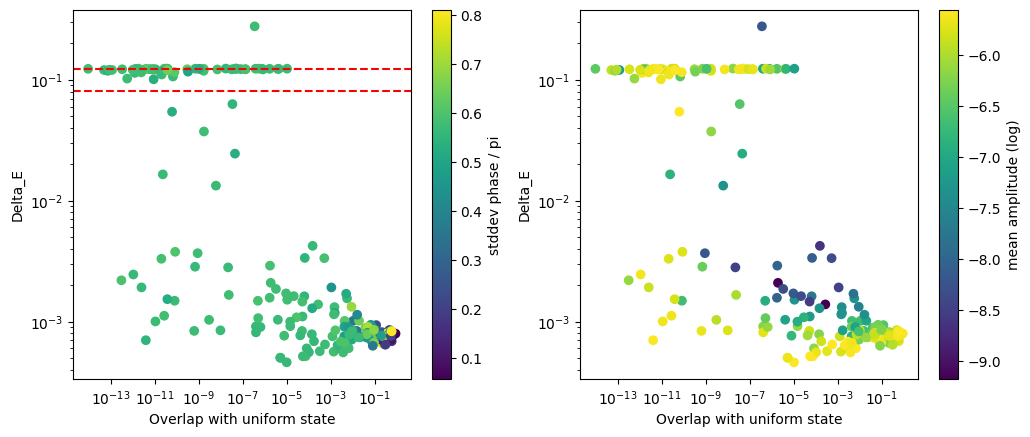

In [30]:
%matplotlib inline
# Scatter each hypothesis value vs the measured infidelity (uses df_eval if present)
infidelity_ansatz_overlap = [abs(sum(psi_1))**2 / len(psi_1) for psi_1 in df_rot_filter.psi_0.values]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

ax[0].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=(df_rot_filter.std_phase/np.pi), cmap='viridis')
ax[0].set_xlabel("Overlap with uniform state")
ax[0].set_ylabel("Delta_E")
m = ax[0].collections[-1]  # get the scatter collection just created
cbar0 = fig.colorbar(m, ax=ax[0])
cbar0.set_label('stddev phase / pi')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(infidelity_ansatz_overlap, df_rot_filter.Delta_E, c=np.log(df_rot_filter.mean_amplitude), cmap='viridis')
ax[1].set_xlabel("Overlap with uniform state")
ax[1].set_ylabel("Delta_E")
m1 = ax[1].collections[-1]  # get the scatter collection just created
cbar1 = fig.colorbar(m1, ax=ax[1])
cbar1.set_label('mean amplitude (log)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[0].axhline(np.abs((spec[6]-spec[0])/spec[0]), color='red', linestyle='--', label='Fifth Excited State Energy Gap')
ax[0].axhline(np.abs((spec[1]-spec[0])/spec[0]), color='red', linestyle='--', label='First Excited State Energy Gap')

In [ ]:
df_rot_filter.head()

,psi,psi_0,Delta_E,E_exact,E_var,infidelity,file,alpha,diag_shift,input_file,...,seed,show_progress,std_phase,IPR,SPCA,Renyi_2,idx,Jij_0,Jij_1,hs
0,"[(-0.040752035-0.039519638j), (-0.0050275954+0...","[(0.042468284564090346+0.04138391902043906j), ...",0.003774,-54.266214,-54.061392,0.020261,/scratch/shared/data/data_random_rotated_rbm/r...,1,0.03,couplings69.csv,...,1234,False,1.892054,0.000112,0.996148,9.099033,50,"[[0.6283186089651995, -0.5881337839196621, 0.9...","[[-0.2765512950044591, -0.38745989436389144, -...","[-0.003102261129499888, 0.7117812323986873, 0...."
2,"[(0.38683254+0.13720681j), (0.10492565-0.06790...","[(0.3923338655248886-0.1325965973547148j), (0....",0.000754,-54.266214,-54.225280,0.002721,/scratch/shared/data/data_random_rotated_rbm/r...,1,0.03,couplings69.csv,...,1234,False,1.501967,0.034044,0.993030,3.380088,50,"[[-0.17484003822257568, 1.4038327361103364, -0...","[[-0.2164242939329765, -0.5589944742884759, -0...","[0.14366793610037065, 0.19107129672596798, -0...."
5,"[(0.00036407888+7.008843e-05j), (0.00042013222...",[(-9.099873303324326e-05+0.0003039908307517223...,0.000850,-54.266214,-54.220110,0.004108,/scratch/shared/data/data_random_rotated_rbm/r...,1,0.03,couplings69.csv,...,1234,False,0.352327,0.000180,0.998728,8.622353,50,"[[0.18897439623270332, -0.794559710276619, 0.3...","[[-2.310435566402161, 0.13440538615875267, 0.2...","[-0.6914774097979925, 0.2341761306784532, -0.0..."
6,"[(-3.4890847e-05+1.6826774e-05j), (-7.876495e-...",[(1.3937813576173205e-06+1.4408353248602385e-0...,0.123372,-54.266214,-47.571295,0.999925,/scratch/shared/data/data_random_rotated_rbm/r...,1,0.03,couplings69.csv,...,1234,False,1.837417,0.056419,0.997299,2.874952,50,"[[0.16756803700186784, -1.439096297785967, -0....","[[-0.2859396939413369, 0.7509137695489426, 0.2...","[-0.3082350122972982, 0.22500306839819517, 0.6..."
9,"[(-6.39743e-05-7.3311254e-05j), (3.0388828e-05...",[(-0.00015645766747465496-3.501496441141524e-0...,0.000785,-54.266214,-54.223621,0.003508,/scratch/shared/data/data_random_rotated_rbm/r...,1,0.03,couplings69.csv,...,1234,False,1.768933,0.003158,0.994350,5.757728,50,"[[1.3062649828036572, -0.3489650886681277, -0....","[[-0.574143785689221, -0.6825305874591096, 0.8...","[-0.44363891978083364, -0.581766010241662, -0...."
